### Importing Libraries and Initializing Warnings

In [1]:
import pandas as pd
import numpy as np
import math
import string
import warnings
from collections import Counter

# NLP related imports
from nltk import pos_tag
from nltk.corpus import stopwords, wordnet
from nltk.stem import WordNetLemmatizer

# Machine Learning related imports
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score, classification_report
from sklearn import metrics
from sklearn.preprocessing import StandardScaler

# Association rule mining
from mlxtend.frequent_patterns import apriori
from mlxtend.preprocessing import TransactionEncoder

# Suppress warnings
warnings.filterwarnings('ignore')

### Data Preprocessing Function

In [ ]:
def preprocessing(df):
    """Preprocess the text data"""
    # Create new dataframe with required columns
    data = pd.DataFrame()
    data["text"] = df["text"]
    
    # Encode labels
    le = LabelEncoder()
    data["label_encode"] = le.fit_transform(df["category"])
    data["label_encode"] = data["label_encode"].astype(str)
    data["label"] = df["category"]
    
    # Text preprocessing steps
    data["text"] = data["text"].str.lower()  # Convert to lowercase
    data["text"] = data["text"].str.replace("'s", "")  # Remove 's
    
    # Remove stopwords
    stop_words = set(stopwords.words("english"))
    data['text'] = data['text'].apply(
        lambda x: " ".join(word for word in x.split() if word not in stop_words)
    )
    
    # Remove punctuations and non-alphabetic tokens
    data['text'] = data['text'].apply(remove_punctuations)
    data['text'] = data['text'].apply(
        lambda x: " ".join(word for word in x.split() if word.isalpha())
    )
    
    # Lemmatization
    data["text"] = data["text"].apply(lemmatize_words)
    
    return data

def remove_punctuations(text):
    """Remove punctuation marks from text"""
    return text.translate(str.maketrans('', '', string.punctuation))

def lemmatize_words(text):
    """Lemmatize words with appropriate POS tags"""
    lemmatizer = WordNetLemmatizer()
    wordnet_map = {
        "N": wordnet.NOUN, 
        "V": wordnet.VERB, 
        "J": wordnet.ADJ, 
        "R": wordnet.ADV
    }
    pos_tagged_text = pos_tag(text.split())
    return " ".join([
        lemmatizer.lemmatize(word, wordnet_map.get(pos[0], wordnet.NOUN)) 
        for word, pos in pos_tagged_text
    ])

### Feature Extraction

In [4]:
def create_tfidf_dataframe(X_train, y_train, X_test, y_test, ngram_range=(1, 1), min_df=10, max_df=85):
    """Creates TF-IDF feature DataFrames for training and testing data."""
    
    # Initialize the TF-IDF Vectorizer
    tfidf = TfidfVectorizer(encoding='utf-8',
                             ngram_range=ngram_range,
                             lowercase=False,
                             max_df=max_df,
                             min_df=min_df,
                             norm='l2',
                             sublinear_tf=True)

    # Fit and transform the training data
    features_train = tfidf.fit_transform(X_train).toarray()
    
    # Create DataFrame for training features
    df_train = pd.DataFrame(features_train, columns=tfidf.get_feature_names_out())
    df_train['labels'] = y_train.reset_index(drop=True)

    # Display the number of features extracted from TF-IDF
    print(f"Jumlah fitur yang diekstraksi dari TF-IDF: {df_train.shape[1] - 1}")

    # Transform the testing data
    features_test = tfidf.transform(X_test).toarray()
    
    # Create DataFrame for testing features
    df_test = pd.DataFrame(features_test, columns=tfidf.get_feature_names_out())
    df_test['labels'] = y_test.reset_index(drop=True)

    return df_train, df_test

In [5]:
def collect_features(df_train):
    class_features = {'0': [], '1': [], '2': []}
    for idx, row in df_train.iterrows():
        label = df_train.loc[idx, 'labels']
        features = [str(col) for col in df_train.columns[:-1] if df_train.loc[idx, col] != 0]
        if label in class_features:
            class_features[label].append(features)
    return class_features['0'], class_features['1'], class_features['2']

In [6]:
# Compute all-confidence measure
def compute_allconf(first_candidate_set, frequent_itemsets):
    frequent_itemsets['all_conf'] = 0.0
    for idx, row in frequent_itemsets.iterrows():
        itemset = row['itemsets']
        supp_itemset = row['support']
        item_supports = [first_candidate_set[i + 1] for item in itemset for i in range(0, len(first_candidate_set), 2) if item == first_candidate_set[i]]
        max_support = max(item_supports) if item_supports else 1
        frequent_itemsets.at[idx, 'all_conf'] = supp_itemset / max_support
    return frequent_itemsets

In [7]:
# Feature Selection - Pruning Functions
def prune_itemset(all_conf_threshold, frequent_itemsets):
    # Prune itemsets with all_conf <= threshold
    frequent_itemsets_conf = frequent_itemsets[
        frequent_itemsets['all_conf'] <= all_conf_threshold
    ].copy()
    
    # Create dictionary of itemsets and their all-confidence values
    all_itemsets = frequent_itemsets_conf['itemsets'].tolist()
    all_itemsets_all_conf = frequent_itemsets_conf['all_conf'].tolist()
    all_itemset_dict = dict(zip(map(float, all_itemsets_all_conf), all_itemsets))
    
    # Prune subsets with lower all-confidence
    indices_to_remove = []
    for idx, row in frequent_itemsets_conf.iterrows():
        item1 = row['itemsets']
        allconf_item1 = row['all_conf']
        
        for allconf, itemset in all_itemset_dict.items():
            if (len(item1) < len(itemset) and 
                set(item1).issubset(set(itemset)) and 
                allconf_item1 <= allconf):
                indices_to_remove.append(idx)
                break
    
    return frequent_itemsets_conf.drop(indices_to_remove)

In [8]:
# Extract frequent features based on threshold
def get_features(filtered_itemsets, frequency_threshold=0.048):
    counter = Counter(x for xs in filtered_itemsets for x in set(xs))
    n_items = len(counter)
    for key in counter:
        counter[key] = float(counter[key]) / n_items
    frequent_features = {k: v for k, v in counter.items() if v > frequency_threshold}
    return list(frequent_features.keys())

In [9]:
# Feature Selection - Association Rule Mining
def fs_ass(transactions):
    te = TransactionEncoder()
    te_array = te.fit(transactions).transform(transactions)
    df = pd.DataFrame(te_array, columns=te.columns_)
    itemsets_1 = apriori(df, min_support=0.01, max_len=1, use_colnames=True)
    first_candidate_set = []
    for _, row in itemsets_1.iterrows():
        first_candidate_set.extend([''.join(row['itemsets']), row['support']])
    frequent_itemsets = apriori(df, min_support=0.045, use_colnames=True)
    frequent_itemsets['length'] = frequent_itemsets['itemsets'].apply(len)
    frequent_itemsets = frequent_itemsets[frequent_itemsets['length'] > 1].copy()
    frequent_itemsets = compute_allconf(first_candidate_set, frequent_itemsets)
    frequent_itemsets_pruned = frequent_itemsets[frequent_itemsets['all_conf'] <= 0.13]
    filtered_itemsets = frequent_itemsets_pruned['itemsets'].tolist()
    return get_features(filtered_itemsets)

In [10]:
# Feature Fitting
def fit_features(df, features_by_class):
    df = df.copy()
    n_cols = len(df.columns)
    
    for idx, row in df.iterrows():
        label = df.loc[idx, 'labels']
        features = features_by_class.get(label, [])
        
        for col in df.columns[:n_cols-1]:
            if df.loc[idx, col] != 0:
                df.loc[idx, col] = 1 if col in features else 0
                
    return df

In [11]:
# Load and preprocess data
df_bbc = pd.read_csv('SPAM.csv', encoding="utf-8")
data = pd.DataFrame()
data["text"] = df_bbc["text"]
data["label_encode"] = LabelEncoder().fit_transform(df_bbc["category"]).astype(str)
data["label"] = df_bbc["category"]
data

,text,label_encode,label
0,"Go until jurong point, crazy.. Available only ...",0,ham
1,Ok lar... Joking wif u oni...,0,ham
2,Free entry in 2 a wkly comp to win FA Cup fina...,1,spam
3,U dun say so early hor... U c already then say...,0,ham
4,"Nah I don't think he goes to usf, he lives aro...",0,ham
...,...,...,...
5567,This is the 2nd time we have tried 2 contact u...,1,spam
5568,Will ü b going to esplanade fr home?,0,ham
5569,"Pity, * was in mood for that. So...any other s...",0,ham
5570,The guy did some bitching but I acted like i'd...,0,ham


In [12]:
# Text preprocessing
data["text"] = data["text"].str.lower().str.replace("'s", "")
stop_words = set(stopwords.words("english"))
data['text'] = data['text'].apply(lambda x: " ".join(x for x in x.split() if x not in stop_words))
data['text'] = data['text'].apply(lambda x: x.translate(str.maketrans('', '', string.punctuation)))
data['text'] = data['text'].apply(lambda x: " ".join(x for x in x.split() if x.isalpha()))

lemmatizer = WordNetLemmatizer()
wordnet_map = {"N": wordnet.NOUN, "V": wordnet.VERB, "J": wordnet.ADJ, "R": wordnet.ADV}
data["text"] = data["text"].apply(lambda text: " ".join([lemmatizer.lemmatize(word, wordnet_map.get(pos[0], wordnet.NOUN)) 
                                                         for word, pos in pos_tag(text.split())]))

print("Sample of preprocessed data:")
data

Sample of preprocessed data:


,text,label_encode,label
0,go jurong point crazy available bugis n great ...,0,ham
1,ok lar joking wif u oni,0,ham
2,free entry wkly comp win fa cup final tkts may...,1,spam
3,u dun say early hor u c already say,0,ham
4,nah think go usf life around though,0,ham
...,...,...,...
5567,time try contact u u pound prize claim easy ca...,1,spam
5568,ü b go esplanade fr home,0,ham
5569,pity mood that soany suggestion,0,ham
5570,guy bitch act like id interested buying someth...,0,ham


      frequency
get         684
call        652
go          554
im          464
ur          390
come        326
know        281
ok          278
ltgt        276
free        275
like        253
good        248
send        247
day         242
want        240
ill         239
time        234
now         231
love        230
say         226


<Figure size 1000x600 with 0 Axes>

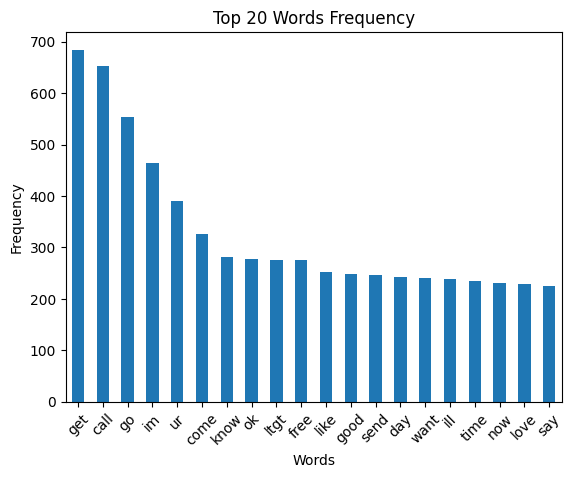

In [13]:
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer

texts = data['text'].tolist()  # Ganti dengan nama kolom yang tepat

# Menghitung frekuensi kata
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(texts)
word_freq = X.toarray().sum(axis=0)

# Membuat DataFrame untuk menyimpan frekuensi kata
word_freq_df = pd.DataFrame(word_freq, index=vectorizer.get_feature_names_out(), columns=['frequency'])
word_freq_df = word_freq_df.sort_values(by='frequency', ascending=False)

# Menampilkan 20 kata teratas
print(word_freq_df.head(20))

# Visualisasi distribusi frekuensi
plt.figure(figsize=(10, 6))
word_freq_df.head(20).plot(kind='bar', legend=False)
plt.title('Top 20 Words Frequency')
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.show()

In [14]:
# Split data
X_train, X_test, y_train, y_test = train_test_split(
    data['text'], data['label'], 
    test_size=0.30, 
    random_state=8
)

In [15]:
df_train, df_test = create_tfidf_dataframe(X_train, y_train, X_test, y_test, ngram_range=(1, 1), min_df=10, max_df=0.85)

Jumlah fitur yang diekstraksi dari TF-IDF: 590


In [16]:
df_train.columns

Index(['abiola', 'able', 'abt', 'account', 'actually', 'add', 'aft',
       'afternoon', 'again', 'age',
       ...
       'yeah', 'year', 'yes', 'yesterday', 'yet', 'yo', 'you', 'yr', 'yup',
       'labels'],
      dtype='object', length=591)

In [17]:
df_train['abiola'].unique()

array([0.        , 0.33752415, 0.26220968, 0.57071281, 0.46206644,
       0.52376662, 0.52204883, 0.35483818, 0.31322184, 0.34447678,
       0.49626945])

In [18]:
# Collect features by class
class_transactions = []

# Mendapatkan daftar label unik dari kolom 'labels'
for label in df_train['labels'].unique():
    transactions = []
    # Mengiterasi setiap baris data pada DataFrame yang memiliki label sesuai kelas saat ini
    for index, row in df_train[df_train['labels'] == label].iterrows():
        # Mengumpulkan fitur (kata atau n-gram) yang memiliki nilai TF-IDF tidak nol
        features = [c for c in df_train.columns[:-1] if row[c] != 0]
        transactions.append(features)
    class_transactions.append(transactions)

print("\nExtracting features for each class...")

# Menampilkan hasil ekstraksi untuk setiap kelas
for i, transactions in enumerate(class_transactions):
    print(f"\nKelas {df_train['labels'].unique()[i]}: ")
    for j, features in enumerate(transactions[:5]):  # Menampilkan 5 dokumen pertama sebagai contoh
        print(f"  Dokumen {j+1}: {features}")

# Menampilkan jumlah total dokumen yang diekstraksi per kelas
for i, transactions in enumerate(class_transactions):
    print(f"\nTotal dokumen untuk kelas {df_train['labels'].unique()[i]}: {len(transactions)}")


Extracting features for each class...

Kelas ham: 
  Dokumen 1: ['boytoy']
  Dokumen 2: ['ok']
  Dokumen 3: ['call', 'dont', 'important', 'pick', 'something', 'tell']
  Dokumen 4: ['it', 'need']
  Dokumen 5: ['dont', 'know']

Kelas spam: 
  Dokumen 1: ['contact', 'look', 'make', 'secret', 'think', 'ur']
  Dokumen 2: ['every', 'now', 'play', 'shopping', 'start', 'store', 'text', 'week', 'win']
  Dokumen 3: ['be', 'first', 'know', 'name', 'new', 'prize', 'pub', 'stop', 'txt']
  Dokumen 4: ['call', 'camera', 'close', 'congrats', 'cost', 'mobile', 'nokia', 'phone', 'post', 'video']
  Dokumen 5: ['eye', 'keep', 'mobile', 'prize', 'soon', 'ur', 'visit', 'win', 'winner']

Total dokumen untuk kelas ham: 3384

Total dokumen untuk kelas spam: 516


TF-IDF memberikan bobot lebih besar pada kata yang sering muncul dalam satu kelas tetapi jarang muncul di kelas lain. Ini menyebabkan kata-kata unik atau spesifik pada suatu kelas (misalnya kata yang lebih sering muncul dalam kelas spam) lebih mungkin muncul sebagai fitur yang signifikan untuk kelas tersebut.

In [51]:
features_by_class = {} # Dictionary yang menyimpan fitur-fitur yang diekstraksi untuk setiap kelas.
min_support_values = [0.02] # Nilai minimum support yang akan digunakan untuk ekstraksi itemsets menggunakan algoritma Apriori.

for i, transactions in enumerate(class_transactions):
    te = TransactionEncoder() # Mengubah data transaksi (list of lists) menjadi format DataFrame biner yang bisa digunakan oleh algoritma Apriori
    te_ary = te.fit(transactions).transform(transactions)
    df = pd.DataFrame(te_ary, columns=te.columns_)
    
    for min_support in min_support_values: # Ekstraksi Itemsets
        itemsets_1 = apriori(df, min_support=min_support, max_len=1, use_colnames=True)
        firstCandidateSet = [item for sublist in itemsets_1['itemsets'].tolist() for item in sublist]
        # Mencari Frequent Itemsets dan Menghitung All-Confidence
        frequent_itemsets = apriori(df, min_support=min_support, use_colnames=True)
        frequent_itemsets['length'] = frequent_itemsets['itemsets'].apply(lambda x: len(x))
        frequentitemsets_without_1st = frequent_itemsets[frequent_itemsets['length'] > 1].copy()
        frequentitemsets_without_1st['all_conf'] = 0
        
        # Menghitung All-Confidence untuk Setiap Itemset
        support = itemsets_1.set_index('itemsets')['support'].to_dict()
        
        for idx, row in frequentitemsets_without_1st.iterrows():
            supp_temp = row['support']
            max_itemset = max([support.get(frozenset([i]), 0) for i in row['itemsets'] if frozenset([i]) in support], default=0)
            frequentitemsets_without_1st.at[idx, 'all_conf'] = supp_temp / max_itemset if max_itemset else 0

        # Pruning Itemsets Berdasarkan All-Confidence
        frequent_itemsets_pruned = frequentitemsets_without_1st[frequentitemsets_without_1st['all_conf'] <= 0.13]
        filtered_itemsets = frequent_itemsets_pruned['itemsets'].tolist()
        # Ekstraksi Fitur berdasarkan Frekuensi Item
        features = [k for k, v in Counter(x for xs in filtered_itemsets for x in set(xs)).items() if v / len(filtered_itemsets) <= 0.048]
        features_by_class[str(i)] = features

total_features = sum(len(features) for features in features_by_class.values())
print(f"\nTotal number of extracted features: {total_features}")


Total number of extracted features: 51


Jika min_support_values = 0.0003 akan terjadi MemoryError: Unable to allocate 4.22 GiB for an array with shape (516, 8776358) and data type bool

Hal tsb terjadi karena min_support terlalu kecil dan menyebabkan algoritma Apriori memilih banyak itemsets

In [53]:
# Membagi dataset menjadi X dan y
X_train = df_train.drop('labels', axis=1)  # Menghapus kolom 'labels' untuk fitur
y_train = df_train['labels']  # Menyimpan kolom 'labels' sebagai target
X_test = df_test.drop('labels', axis=1)  # Sama untuk dataset test
y_test = df_test['labels']

In [55]:
scaler = StandardScaler()

# Fit features for train/test sets
for df in [df_train, df_test]:
    for index, row in df.iterrows():
        label = row['labels']
        for c in df.columns[:-1]:
            if c in features_by_class.get(str(label), []):
                df.at[index, c] = 1

# Prepare train/test sets
X_train = df_train.drop('labels', axis=1)
y_train = df_train['labels']
X_test = df_test.drop('labels', axis=1)
y_test = df_test['labels']

# Normalize the features
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train and evaluate models
models = {
    'Random Forest': RandomForestClassifier(random_state=1, n_estimators=100, max_depth=10),
    'Logistic Regression': LogisticRegression(random_state=1, C=1.0, solver='liblinear'),
    'Decision Tree': DecisionTreeClassifier(random_state=1, max_depth=5),
    'GaussianNB': GaussianNB()
}

results = []

for name, model in models.items():
    model.fit(X_train_scaled, y_train)
    predictions = model.predict(X_test_scaled)
    
    accuracy = metrics.accuracy_score(y_test, predictions) * 100
    f1 = math.ceil(metrics.f1_score(y_test, predictions, average='micro') * 100)
    
    results.append({
        'Model': name,
        'Accuracy': accuracy,
        'F-measure': f1
    })

results_df = pd.DataFrame(results).set_index('Model')
print("\nClassification Results:")
print(results_df)


Classification Results:
                      Accuracy  F-measure
Model                                    
Random Forest        94.019139         95
Logistic Regression  96.830144         97
Decision Tree        94.078947         95
GaussianNB           73.803828         74


In [ ]:
# # Fit features for train/test sets
# for df in [df_train, df_test]:
#     for index, row in df.iterrows():
#         label = row['labels']
#         for c in df.columns[:-1]:
#             if row[c] != 0:
#                 df.at[index, c] = 1 if c in features_by_class.get(str(label), []) else 0

# # Prepare train/test sets
# X_train = df_train.drop('labels', axis=1)
# y_train = df_train['labels']
# X_test = df_test.drop('labels', axis=1)
# y_test = df_test['labels']

# # Train and evaluate models
# models = {
#     'Random Forest': RandomForestClassifier(random_state=1),
#     'Logistic Regression': LogisticRegression(random_state=1),
#     'Decision Tree': DecisionTreeClassifier(random_state=1),
#     'GaussianNB': GaussianNB()
# }
# results = []

# for name, model in models.items():
#     model.fit(X_train, y_train)
#     predictions = model.predict(X_test)
    
#     accuracy = metrics.accuracy_score(y_test, predictions) * 100
#     f1 = math.ceil(metrics.f1_score(y_test, predictions, average='micro') * 100)
    
#     results.append({
#         'Model': name,
#         'Accuracy': accuracy,
#         'F-measure': f1
#     })

# results_df = pd.DataFrame(results).set_index('Model')
# print("\nClassification Results:")
# print(results_df)


Classification Results:
                      Accuracy  F-measure
Model                                    
Random Forest        86.184211         87
Logistic Regression  86.184211         87
Decision Tree        86.184211         87
GaussianNB           86.184211         87


In [ ]:
# from sklearn.utils import resample

# # Step 1: Enhance Feature Transformation for train/test sets
# for df in [df_train, df_test]:
#     for index, row in df.iterrows():
#         label = row['labels']
#         for c in df.columns[:-1]:
#             # Transform feature based on features_by_class with additional conditions
#             if row[c] != 0:
#                 if c in features_by_class.get(str(label), []):
#                     df.at[index, c] = 1  # Feature is important for this class
#                 else:
#                     df.at[index, c] = 0.5  # Feature present but not specific to this class
#             else:
#                 df.at[index, c] = 0  # Feature absent

# # Step 2: Check class distribution and balance if necessary
# class_counts = y_train.value_counts()
# print("Class Distribution Before Balancing:\n", class_counts)

# # Balance training data by oversampling the minority class if imbalance is detected
# max_class_count = class_counts.max()
# if class_counts.min() < 0.5 * max_class_count:
#     balanced_dfs = []
#     for label in class_counts.index:
#         label_df = df_train[df_train['labels'] == label]
#         balanced_dfs.append(resample(label_df, replace=True, n_samples=max_class_count, random_state=1))
#     df_train = pd.concat(balanced_dfs)
#     X_train = df_train.drop('labels', axis=1)
#     y_train = df_train['labels']
# else:
#     X_train = df_train.drop('labels', axis=1)
#     y_train = df_train['labels']

# # Prepare test set
# X_test = df_test.drop('labels', axis=1)
# y_test = df_test['labels']

# # Step 3: Train and evaluate models
# models = {
#     'Random Forest': RandomForestClassifier(random_state=42),
#     'Logistic Regression': LogisticRegression(random_state=42, max_iter=1000),
#     'Decision Tree': DecisionTreeClassifier(random_state=42),
#     'GaussianNB': GaussianNB()
# }

# results = []
# for name, model in models.items():
#     model.fit(X_train, y_train)
#     predictions = model.predict(X_test)
    
#     accuracy = metrics.accuracy_score(y_test, predictions) * 100
#     f1 = math.ceil(metrics.f1_score(y_test, predictions, average='micro') * 100)
    
#     results.append({
#         'Model': name,
#         'Accuracy': accuracy,
#         'F-measure': f1
#     })

# results_df = pd.DataFrame(results).set_index('Model')
# print("\nClassification Results:")
# print(results_df)


Class Distribution Before Balancing:
 ham     3384
spam     516
Name: labels, dtype: int64

Classification Results:
                      Accuracy  F-measure
Model                                    
Random Forest        86.184211         87
Logistic Regression  86.184211         87
Decision Tree        86.184211         87
GaussianNB           86.184211         87
